# 23_04_25_06_erythroid_lineage_下游分析2_CellDancer对于基因的描述

In [1]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import anndata as ad
import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 读取结果

In [2]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
# adata_dir = "tmp/erythroid_lineage_cluster/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. subsample_adata

In [3]:
subsample_adata = scv.read("./tmp/erythroid_lineage2/subsample_adata.h5ad")
subsample_adata

AnnData object with n_obs × n_vars = 250 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

3. model

In [4]:
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage/model", adata=adata, use_gpu=True)
velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage2/model", adata=adata, use_gpu=True)

INFO     File tmp/erythroid_lineage2/model/model.pt already downloaded                                             


## 2. 对应Fig2e

In [5]:
time_key = "latent_time"

### 2.1 挑选合适的伪时间

1. 模型得到的是一个细胞*基因的矩阵,直接对行取平均,得到的效果不太好。

In [6]:
# 模型得到的是一个细胞*基因的矩阵,直接对行取平均,得到的效果不太好
time_key1 = "%s_1"%time_key
velovgi.pp.moment_layer_attribute(adata, subsample_adata, attribute="fit_t")
adata.obs[time_key1] = adata.layers["fit_t"].mean(axis=1).A[:, 0]

2. 只能手动给个大概的时间顺序

In [7]:
import numpy as np


latent_time = np.zeros(adata.obs.shape[0])

# 离散的时间序列
# cluster2time = {
#     "Blood progenitors 1" : 5,
#     "Blood progenitors 2" : 10,
#     "Erythroid1" : 15,
#     "Erythroid2" : 20,
#     "Erythroid3" : 25,
# }
# adata.obs["latent_time"] = adata.obs[cluster_key].apply(lambda x: cluster2time[x])
# adata.obs["latent_time"] = adata.obs["latent_time"].astype("int")
# 连续的时间序列

# 连续的时间序列，每个聚类的时间随机分配
cluster_list = ["Blood progenitors 1", "Blood progenitors 2", "Erythroid1", "Erythroid2", "Erythroid3"]
time_list = [5,10,15,20,25]
for i in range(len(cluster_list)):
    cluster = cluster_list[i]
    time = time_list[i]
    pre_time = time_list[i-1] if i>0 else 0
    bool_series = adata.obs[cluster_key] == cluster # 提取指定类型
    latent_time[bool_series] = np.linspace(pre_time,time, bool_series.sum()) # 设置时间范围

time_key2 = "%s_2"%time_key
adata.obs[time_key2] = latent_time

3. scVelo本身提供了对时间的构建（最好的方法）

In [8]:
time_key3 =  "velocity_pseudotime"
scv.tl.velocity_pseudotime(adata)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 6 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


4. 对比查看,velocity_pseudotime最合适

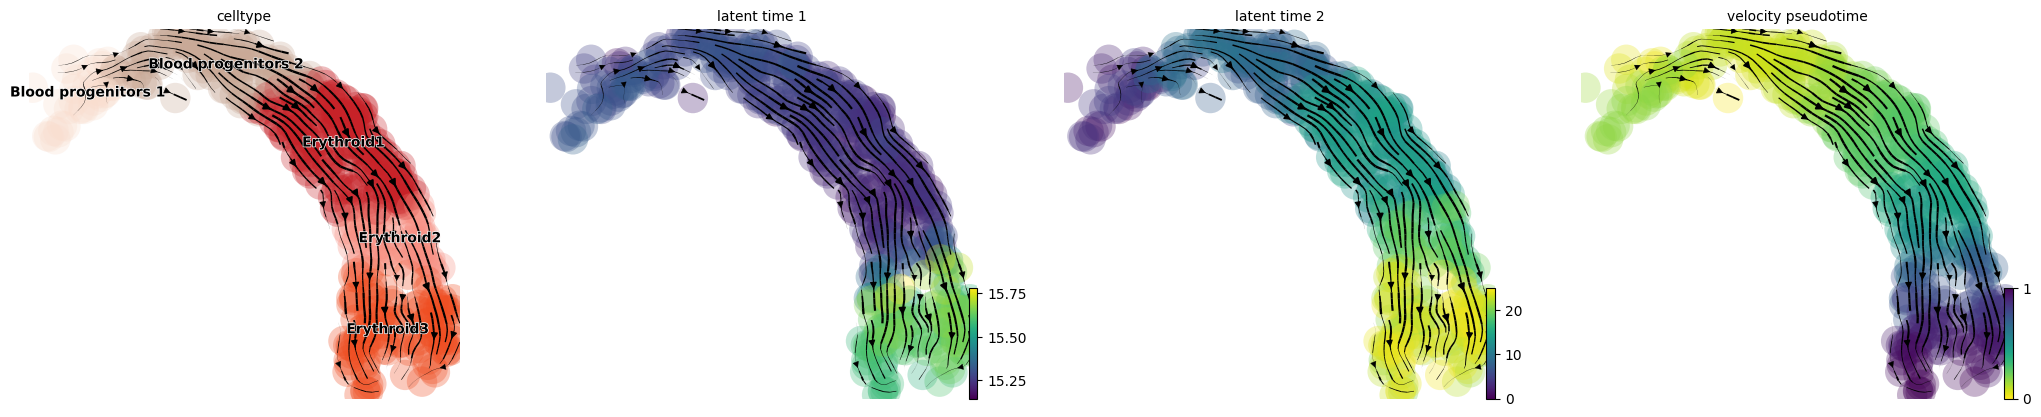

In [9]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, time_key1, time_key2, time_key3])

2. 热图展示

In [10]:
adata.obs[time_key] = adata.obs[time_key3]
adata.obs[time_key].to_csv("latent_time.csv")

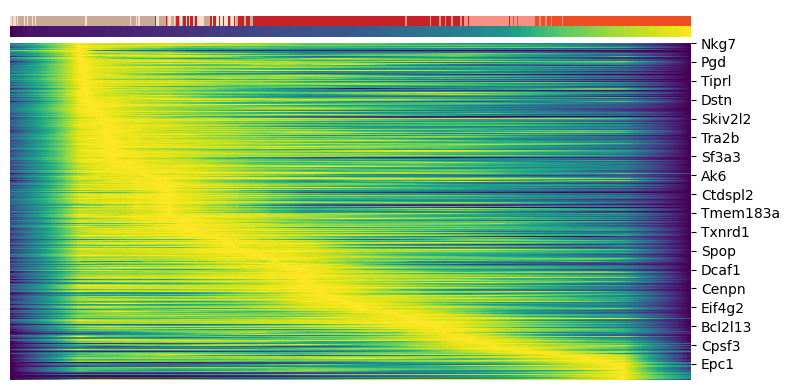

In [11]:
# velovgi_model.get_gene_likelihood(subsample_adata)
top_genes = list(adata.var.index[:2000]) # 这里top_gene暂时这也写,以后可以用marker基因看，或者皮尔森相关系数>0.8(CellDancer)
scv.pl.heatmap(adata, var_names=top_genes, sortby=time_key, col_color=[cluster_key, time_key], n_convolve=100)

3. 单看转录爆发基因的热图，都是在最后的细胞类型中

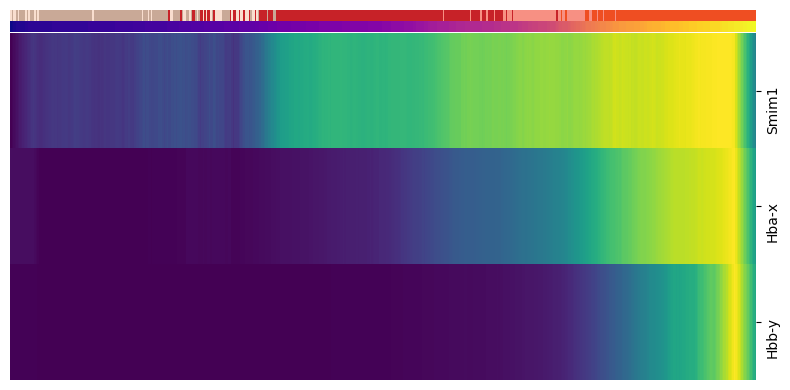

In [12]:
top_genes = ["Hba-x", "Hbb-y", "Smim1"]
ax = scv.pl.heatmap(adata, var_names=top_genes, sortby=time_key, col_color=[cluster_key, time_key], colorbar=True, palette="plasma", show=False)

## 对应Fig2f

1. 对基因聚类

2. 曲线图

3. 富集分析图

## 对应Fig2c

1. 损失

2. 